In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import kagglehub
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import confusion_matrix
import statsmodels.formula.api as smf
#Pentru normalitate
from statsmodels.stats.stattools import jarque_bera
from scipy.stats import shapiro 
from scipy.stats import kstest, norm
#Pentru Homoschedasticitate
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
#Pentru multicolinaritate
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [8]:
def testare_homoschedasticitate(regression,actual):
    residuals = regression.resid
    exog = regression.model.exog
    print("Testul White")
    white_t = het_white(residuals,exog)
    print(white_t)
    print("Test Breuche-Pagan")
    bpt = het_breuschpagan(residuals,exog)
    print(bpt)
    plt.figure(figsize=(10,8))
    plt.scatter(actual,residuals)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Actual vs Predicted")
    plt.show()

In [ ]:
df =  pd.read_csv("World-happiness-report-2024.csv",index_col="Country name")

In [50]:
df.head()

,Region,happy,upperwhisker,lowerwhisker,GDP_capita_logged,Social_support,Life_expectancy,Freedom,Generosity,Coruption,Dystopia + residual,Region_2,cooks_d
Country name,,,,,,,,,,,,,
Finland,Western Europe,7.741,7.815,7.667,1.844,1.572,0.695,0.859,0.142,0.546,2.082,Europe,0.004583
Denmark,Western Europe,7.583,7.665,7.500,1.908,1.520,0.699,0.823,0.204,0.548,1.881,Europe,0.000989
Iceland,Western Europe,7.525,7.618,7.433,1.881,1.617,0.718,0.819,0.258,0.182,2.050,Europe,0.001482
Sweden,Western Europe,7.344,7.422,7.267,1.878,1.501,0.724,0.838,0.221,0.524,1.658,Europe,0.000293
Israel,Middle East and North Africa,7.341,7.405,7.277,1.803,1.513,0.740,0.641,0.153,0.193,2.298,Middle East,0.029344


In [ ]:
df.dropna(inplace=True)

In [33]:
# print(df['Regional indicator'].drop_duplicates())
Asia = ['Southeast Asia','East Asia','South Asia']
Europe = ['Western Europe','Central and Eastern Europe']
North_America = ['United States','Canada']
Australia = ['Australia','New Zealand']
Africa = ['Sub-Saharan Africa']
Countries_not_in_middle_east =['Ukraine','Moldova','Georgia']
African_countries = ["Libya","Algeria","Morocco","Tunisia","Egypt"]

In [34]:
print(Asia)
print(Europe)
print(North_America)
print(Australia)
print(Africa)
print(Countries_not_in_middle_east)
print(African_countries)

['Southeast Asia', 'East Asia', 'South Asia']
['Western Europe', 'Central and Eastern Europe']
['United States', 'Canada']
['Australia', 'New Zealand']
['Sub-Saharan Africa']
['Ukraine', 'Moldova', 'Georgia']
['Libya', 'Algeria', 'Morocco', 'Tunisia', 'Egypt']


In [35]:
df.rename(columns={
    'Log GDP per capita':'GDP_capita_logged',
    'Perceptions of corruption':'Coruption',
    'Healthy life expectancy':'Life_expectancy',
    'Social support':'Social_support',
    'Ladder score':'happy',
    'Regional indicator':'Region',
    'Freedom to make life choices':'Freedom'
},inplace=True)

In [36]:
df['Region_2'] = df.apply(lambda x: 'Asia' if x['Region'] in Asia else
                                              'Europe' if x['Region'] in Europe else
                                              'North_America' if x.name in North_America else
                                              'Australia' if x.name in Australia else
                                              'Africa' if x['Region'] in Africa else
                                              'South America' if x['Region'] =='Latin America and Caribbean' else
                                              'Europe' if x['Region']=='Commonwealth of Independent States' and x.name in Countries_not_in_middle_east else
                                              'Middle East' if x['Region']=='Commonwealth of Independent States' and x.name not in Countries_not_in_middle_east else
                                              'Africa' if x.name in African_countries else 'Middle East',axis=1)

In [37]:
regresie = smf.ols('happy ~C(Region_2)+ Social_support + Life_expectancy '
                            '+ Coruption +GDP_capita_logged + Freedom + Generosity',data=df).fit()
print(regresie.summary())
exog = regresie.model.exog
fit = regresie.fittedvalues
weigths = 1 / (np.power(fit,2))
wls = sm.WLS(df.loc[df.dropna().index,'happy'],exog=exog,weights=weigths).fit()

                            OLS Regression Results                            
Dep. Variable:                  happy   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     57.80
Date:                Mon, 01 Dec 2025   Prob (F-statistic):           1.66e-45
Time:                        14:32:51   Log-Likelihood:                -90.862
No. Observations:                 140   AIC:                             207.7
Df Residuals:                     127   BIC:                             246.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

Testul White
(79.69596591159016, 0.0376171788658607, 1.7919585031634293, 0.0076427847421990215)
Test Breuche-Pagan
(22.400709225981842, 0.033266653417409434, 2.0159490000429434, 0.027767806064241052)


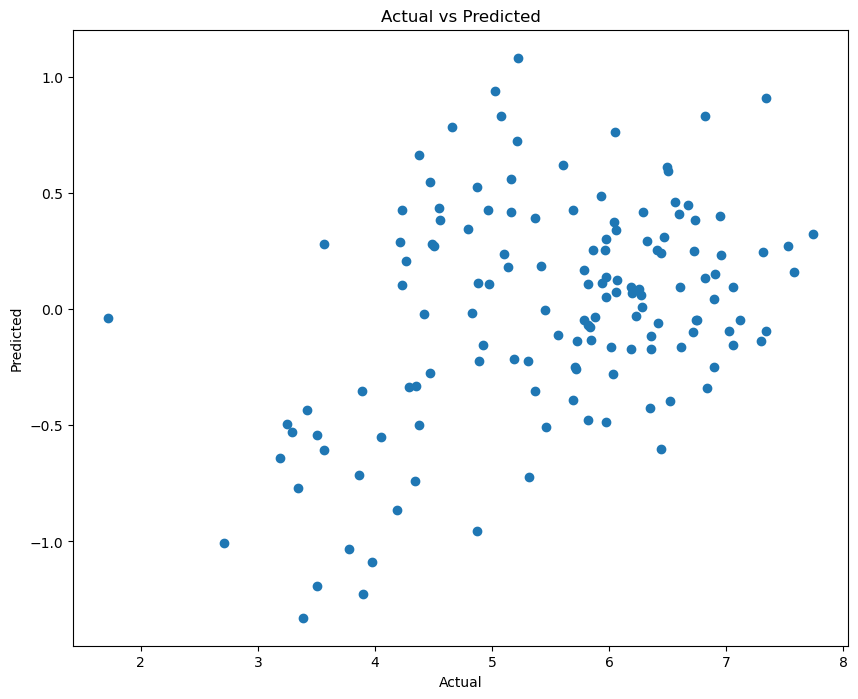

In [38]:
testare_homoschedasticitate(regresie,df.loc[df.dropna().index,'happy'])

In [39]:
print(wls.summary())

                            WLS Regression Results                            
Dep. Variable:                  happy   R-squared:                       0.874
Model:                            WLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     73.36
Date:                Mon, 01 Dec 2025   Prob (F-statistic):           4.32e-51
Time:                        14:32:51   Log-Likelihood:                -107.50
No. Observations:                 140   AIC:                             241.0
Df Residuals:                     127   BIC:                             279.2
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1679      0.184      6.357      0.0

Testul White
(76.62935344552925, 0.0612108808240853, 1.639626762722436, 0.01982142561690172)
Test Breuche-Pagan
(19.89455986462357, 0.06910700946518891, 1.7530493067586668, 0.06311955768112183)


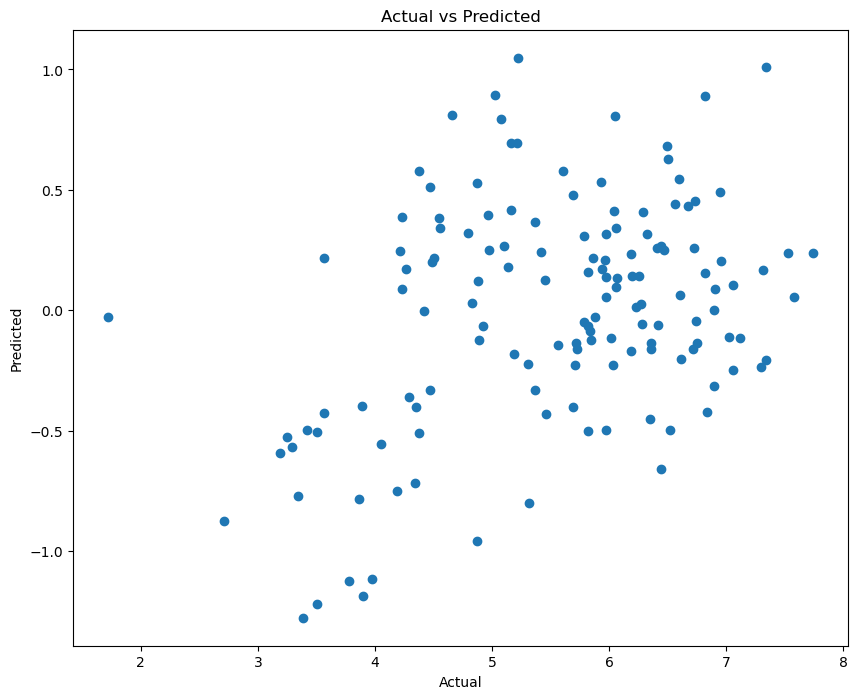

In [40]:
testare_homoschedasticitate(wls,df.loc[df.dropna().index,'happy'])

In [41]:
model_corectat = regresie.get_robustcov_results(cov_type='HC3')
print(model_corectat.summary())

                            OLS Regression Results                            
Dep. Variable:                  happy   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     63.94
Date:                Mon, 01 Dec 2025   Prob (F-statistic):           7.60e-48
Time:                        14:32:52   Log-Likelihood:                -90.862
No. Observations:                 140   AIC:                             207.7
Df Residuals:                     127   BIC:                             246.0
Df Model:                          12                                         
Covariance Type:                  HC3                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

Testul White
(79.69596591159016, 0.0376171788658607, 1.7919585031634293, 0.0076427847421990215)
Test Breuche-Pagan
(22.400709225981842, 0.033266653417409434, 2.0159490000429434, 0.027767806064241052)


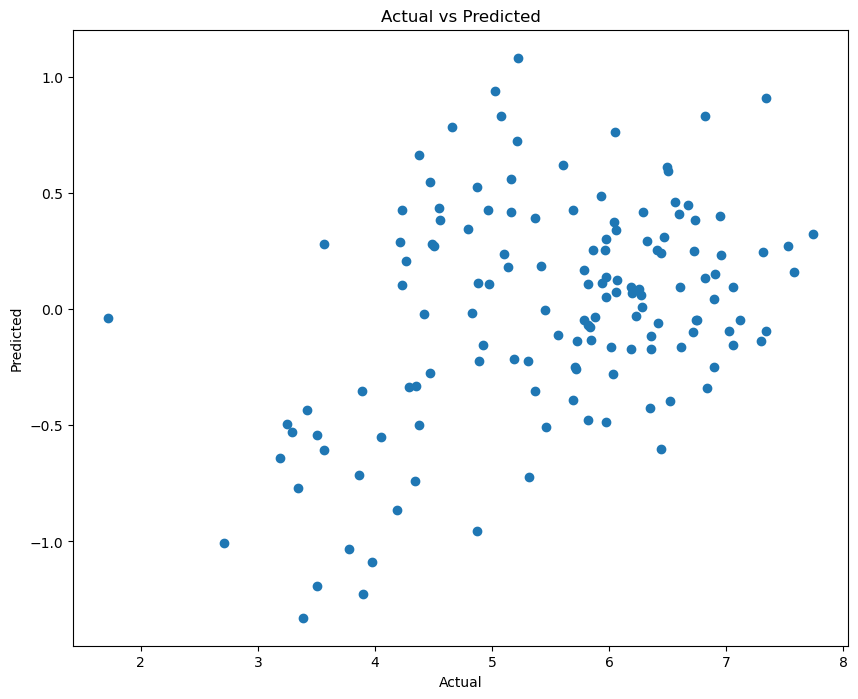

In [42]:
testare_homoschedasticitate(model_corectat,df.loc[df.dropna().index,'happy'])

In [48]:
#Testare normalitate
reziduuri = regresie.resid
jb = jarque_bera(reziduuri)
print("jarque_bera")
print(jb)
print("SHAPIRO")
shapiro_test = shapiro(reziduuri)
print(shapiro_test)
print("Kolmogov Smirnov")
kstest(reziduuri, "norm", args=(reziduuri.mean(), reziduuri.std()))

jarque_bera
(5.397667002835394, 0.06728395361677487, -0.46184803145714803, 3.2685142951498847)
SHAPIRO
ShapiroResult(statistic=0.9819579124450684, pvalue=0.06155088543891907)
Kolmogov Smirnov


KstestResult(statistic=0.07139733680588967, pvalue=0.4524792803249902, statistic_location=-0.17017287111698742, statistic_sign=-1)

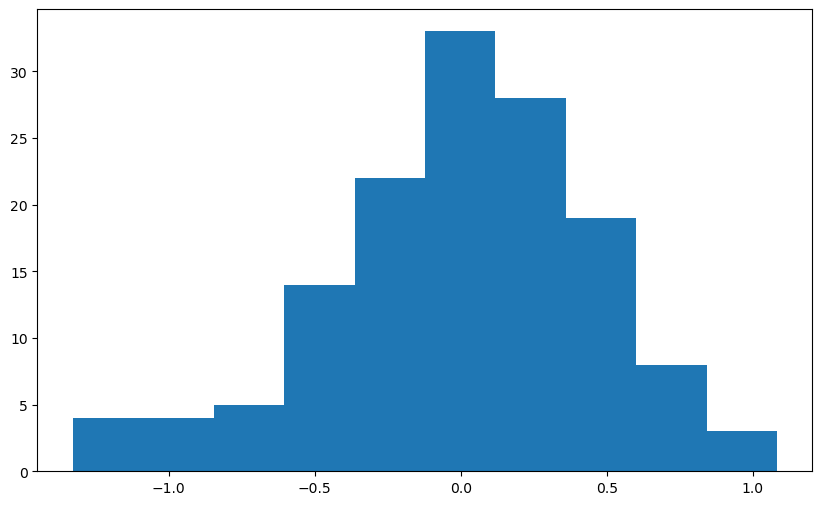

In [49]:
plt.figure(figsize=(10,6))
plt.hist(reziduuri,bins=10)
plt.show()

In [46]:
influence = regresie.get_influence()
cooks_d, p_values = influence.cooks_distance
df['cooks_d'] = cooks_d
influential = df[df['cooks_d'] > 4 / len(df)]

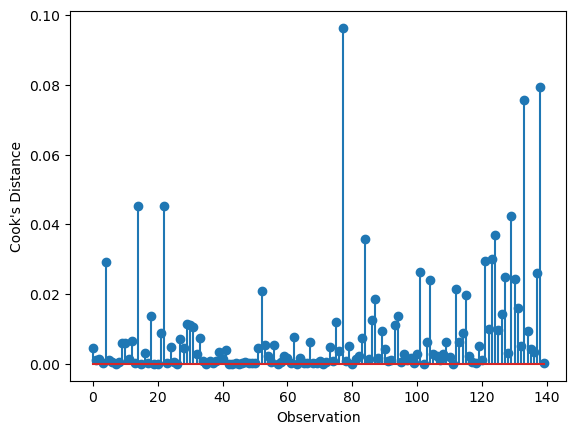

In [47]:
plt.stem(cooks_d)
plt.xlabel('Observation')
plt.ylabel("Cook's Distance")
plt.show()

## To do pt Philipe

1. df.describe() si scrii intr-un document word concluziile pe care le obtii din date (Pt proiect)
2. Cauta surse de date care sa fie cat de cat similare cu ceea ce avem noi (GDP per capita!!!) (Pt proiect)
3. Reformuleaza definitiile de pe kaggle a.i. sa aiba  (Pt proiect)
4. Joaca-te cu diverse forme ale modelului: Baga si scoate variabile din model, vezi care sunt sau nu  (Pt tine + pt proiect)
5. Testeaza ipotezele de normalitate, homoschedasticitate, multicoliniaritate (Pt tine)
6. Intrepreteaza parametriii (Pt tine)